<a href="https://colab.research.google.com/github/Sala0307/AIML-Training/blob/main/Gradient_descent_and_back_propagation%20lr%3D0.6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gradient Descent Tutorial

Link to Presentation: https://docs.google.com/presentation/d/1basYOmB3uW8l-p-v1OChzzYI0bzm-r3dr8wFTRpluhk/edit?usp=sharing

## Import Libraries

In [1]:
import numpy as np
import math
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

## Calculating the gradients of functions

Let us start with a simple function: sum of squares. Its gradient is known as 2*x

In [2]:
def f1(X):
    return torch.sum(torch.square(X))


def grad_f1(X):
    grad = torch.zeros_like(X)
    for i in range(len(X)):
        grad[i] = 2*X[i]
    return grad


Let us see what our function does

In [3]:
x = torch.tensor([1,2,3]);
print('Original X: ', x)
print('f1(x): ',f1(x))
print('Calculated d(f1)/d(x): ',grad_f1(x))

Original X:  tensor([1, 2, 3])
f1(x):  tensor(14)
Calculated d(f1)/d(x):  tensor([2, 4, 6])


We don't need to calculate the gradient function by ourselves. Pytorch provides **autograd** functionality which calculates the gradients for us on the fly. To do that, we need to define a Pytorch tensor with the flag **requires_grad=True**. We also need to make sure all the functions we are applying on the tensor is done using pytorch functions.

For all tensors with requires_grad=True, Pytorch maintains a graph of the operations so that the gradient can be calculated when required, using **backward** function.

In [4]:
x = torch.tensor([4,5,6], dtype=float, requires_grad=True);
print('Original X: ', x)
y = f1(x)
print('f1(x): ', y)
dy = grad_f1(x)
print('Calculated gradient dy/dx: ', dy.data)
# calculate the gradients using autograd
y.backward()
# now dy/dx will be present in x.grad
print('Autograd dy/dx: ', x.grad)

Original X:  tensor([4., 5., 6.], dtype=torch.float64, requires_grad=True)
f1(x):  tensor(77., dtype=torch.float64, grad_fn=<SumBackward0>)
Calculated gradient dy/dx:  tensor([ 8., 10., 12.], dtype=torch.float64)
Autograd dy/dx:  tensor([ 8., 10., 12.], dtype=torch.float64)


Let us try a more complex function with multiple steps:
z = (x^2 + y)^3

Let us calculate by hand. Let us break it like this:
w = x^2 + y
z = w^3

dz/dw = 3w^2
dw/dx = 2x
dw/dy = 1
dz/dx = dz/dw*dw/dx  etc.

In [5]:
# input
x = torch.tensor([2], dtype=float, requires_grad=True)
print('original x: ', x)
y = torch.tensor([5], dtype=float, requires_grad=True)
print('original y: ', y)

# calculate our function
def f2(x,y):
  w = x*x + y
  z = w**3
  return w, z

w,z = f2(x,y)
print('intermediate w: ', w.data)
print('z: ', z.data)

original x:  tensor([2.], dtype=torch.float64, requires_grad=True)
original y:  tensor([5.], dtype=torch.float64, requires_grad=True)
intermediate w:  tensor([9.], dtype=torch.float64)
z:  tensor([729.], dtype=torch.float64)


Let us check the gradients computed by Pytorch for the w function:

In [6]:
w.backward()
print('dw/dx : ', x.grad)
print('dw/dy : ', y.grad)

dw/dx :  tensor([4.], dtype=torch.float64)
dw/dy :  tensor([1.], dtype=torch.float64)


Let us calculate the gradients for the z function:

In [7]:
z.backward()

RuntimeError: ignored

In Pytorch, we can't run **backward()** through the same graph twice to save memory. So we have to run the function again or put the flag **retain_graph=True**

In [8]:
# we need to clear all previous gradients, otherwise, it will get added up
x = x.detach()
y = y.detach()
x.requires_grad=True
y.requires_grad=True


w,z = f2(x,y)

z.backward()

print('dz/dx = dz/dw * dw/dx: ', x.grad)
print('dz/dy = dz/dw * dw/dy: ', y.grad)

dz/dx = dz/dw * dw/dx:  tensor([972.], dtype=torch.float64)
dz/dy = dz/dw * dw/dy:  tensor([243.], dtype=torch.float64)


## Questions
* Try with your own functions of multiple steps and multiple variables. Does the calculated gradient match the actual gradient?
* How do we calculate the gradient of a vector?

# Gradient Descent

Let us try to find the minimum of a simple function x^2. First let us look at the graph of the function.

In [9]:
def f3(x):
  return x**2

def plot_function(function, start, end):
  x = torch.linspace(start, end, 1000)
  y = f3(x)
  plt.plot(x,y)




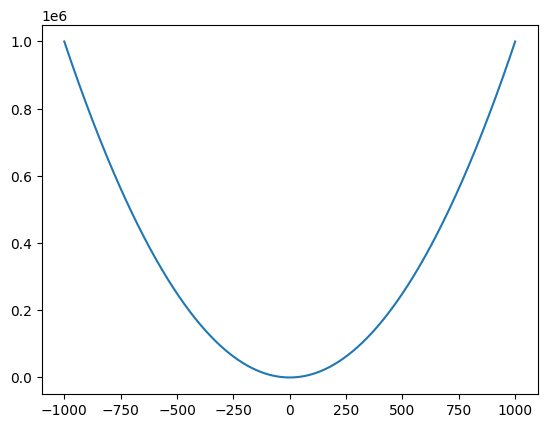

In [10]:
plot_function(f3, -1000,1000)
plt.show()

Here is a function for **Gradient Descent**, where we start with a random **x**, and move slowly in the negative gradient direction

**Note:** Talk about convergence_threshold
- Just a bargain between time and precision
- Near the minima, update rate becomes very slow
- Also, getting an exact match for complex functions is difficult (splly when going stochastic)

In [11]:
def gradient_descent_visualize(function, lr=0.1, convergence_threshold = 0.01, max_iter = 10000):
  x = torch.rand(1, requires_grad=True)
  x_history = []
  for ii in range(max_iter):
    y = function(x)
    y.backward()
    x_new = x - x.grad*lr
    if torch.abs(x_new - x) < convergence_threshold:
      x = x_new
      break
    # store the history of steps so that we can see
    x_history = x_history + [x_new]
    # zero the gradients
    x = x_new.detach()
    x.requires_grad = True

  return x, torch.tensor(x_history)


In [39]:
x, history = gradient_descent_visualize(f3 , lr=0.6)
print(x)

tensor([0.0005], grad_fn=<SubBackward0>)


Let us write a function for visualizing the steps taken

In [40]:
def plot_function_2(function, history):
  y = function(history)
  plt.plot(history, y,color='red', marker='o', fillstyle='full')

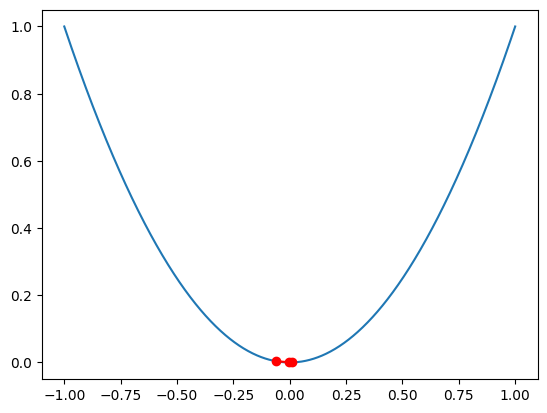

In [41]:
plot_function(f3, -1, 1)
plot_function_2(f3, history)
plt.show()

## Questions
1. Try with different iterations, learning rates and functions. Try non-convex functions and see how it converges!
2. Does changing these values give you better minima estimation?

# Doing it for an MLP!

Let us try to apply the gradient descent algorithm to a multi layer perceptron. The steps are the same. The increased complexity of the function doesn't matter as Autograd calculates the gradient for us.


For a neural network, there are two inputs to the function: f(x, w) where x is the input (image, text etc. ) and w is the weight. The neural network will have a loss function: L(f(x, w)) or L(x, w). We will be doing gradient descent on w using dL/dw and not on x, as we can't control the input.

Instead of using a single learning rate and updating the weights ourselves, Pytorch provides 'optimizers' which implement many algorithmic tricks, like variable learning rates, momentum, weight decay etc. When running gradient descent for an MLP, it is better to use an optimizer instead of manually changing the weights.


The following code is taken from the lab on Day 1

### Defining a simple convolutional model

In [25]:
# CNN with 2 CONV layers and 3 FC layers
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        # self.conv3 = nn.Conv2d(32,32,)
        self.fc1 = nn.Linear(32 * 5 * 5, 512)
        self.fc2 = nn.Linear(512, 128)
        # output layer 10 classes
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # flatten all dimensions except batch
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Take care of the data

In [26]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Classes in CIFAR10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [27]:
print('Training data shape : ', trainset.data.shape, len(trainset.targets))
print('Testing data shape : ', testset.data.shape, len(testset.targets))

# Find the unique numbers from the train labels
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Training data shape :  (50000, 32, 32, 3) 50000
Testing data shape :  (10000, 32, 32, 3) 10000
Total number of outputs :  10
Output classes :  ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Let us write a training function to implement gradient descent:

In [28]:
def train(num_epochs, model, train_loader, loss_func, optimizer):

  # Training mode
  model.train()

  train_losses = []
  train_acc = []

  # Train the model
  for epoch in range(num_epochs):
    running_loss = 0
    running_acc = 0
    for i, (images, labels) in enumerate(train_loader):

      # clear gradients for this training step
      optimizer.zero_grad()

      # Forward pass
      output = model(images)

      # Calculate loss
      loss = loss_func(output, labels)

      # Backpropagation, compute gradients
      loss.backward()

      # Apply gradients
      optimizer.step()

      # Running loss
      running_loss += loss.item()

      # indices of max probabilities
      _, preds = torch.max(output, dim=1)

      # Calculate number of correct predictions
      correct = (preds.float() == labels).sum()
      running_acc += correct

      # Average loss and acc values
      epoch_loss = running_loss / len(train_loader.dataset)
      epoch_acc = running_acc / len(train_loader.dataset)

    train_losses.append(epoch_loss)
    train_acc.append(epoch_acc)
    print ('Epoch {}/{}, Loss: {:.4f}, Accuracy: {:.4f}'.format(epoch + 1, num_epochs, epoch_loss, epoch_acc*100))

  return train_losses, train_acc

Test function

In [29]:
def test_model(model, testloader):
  model.eval()
  correct = 0
  total = 0
  # Deactivate autograd engine (don't compute grads since we're not training)
  with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Calculate outputs by running images through the network
        outputs = model(images)
        # The class with the highest value is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

  print('Accuracy of the network: %d %%' % (
      100 * correct / total))

### Do the training!

In [30]:
# start with a fresh model
model = Net()
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


We need a single value to do backward() on. Thus, we need to use the appropriate loss. The common loss function for classification is cross entropy loss.

In [31]:
# Cross Entropy loss for multi-class classification
criterion = nn.CrossEntropyLoss()

Let us pick one of the many optimizers available in Pytorch. Here we are using SGD. You can substitute with any optimizer from this page: https://pytorch.org/docs/stable/optim.html#per-parameter-options

In [32]:
# SGD optimizer with momentum
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

Here is the training code:

In [33]:
num_epochs = 5  # iterations
train_losses, train_acc = train(num_epochs, model, trainloader, criterion, optimizer)

Epoch 1/5, Loss: 0.0128, Accuracy: 39.5240
Epoch 2/5, Loss: 0.0093, Accuracy: 57.8900
Epoch 3/5, Loss: 0.0077, Accuracy: 65.4140
Epoch 4/5, Loss: 0.0066, Accuracy: 70.3980
Epoch 5/5, Loss: 0.0057, Accuracy: 74.7280


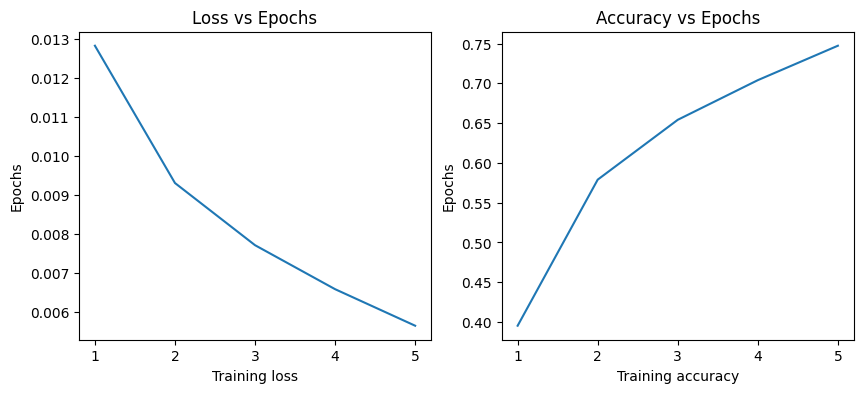

In [34]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2, 1)
ax.plot(np.arange(1,len(train_losses)+1),train_losses)
plt.xlabel('Training loss')
plt.ylabel('Epochs')
ax.set_title('Loss vs Epochs')
ax = fig.add_subplot(1,2, 2)
ax.plot(np.arange(1,len(train_acc)+1),train_acc)
plt.xlabel('Training accuracy')
plt.ylabel('Epochs')
ax.set_title('Accuracy vs Epochs')
plt.show()

In [35]:
# Accuracy on test data after training
test_model(model, testloader)

Accuracy of the network: 66 %


### Questions
1. Try with different hyperparameters of learning rate and momentum
2. Try with different optimizer values.